<a href="https://colab.research.google.com/github/sahil301290/CRBP-3D-to-2.5D/blob/main/02_CRBP_Raw_vs_YOLOv8_EfficientNetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition | CRBP-Raw vs. CRBP-Yolov8
### Using EfficientNetb0 over 105 subjects | Train,val,test: (60,20,20)

In [1]:
!gdown 1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4 -O CRBP-Yolov8.zip
!gdown 1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6 -O CRBP-Raw.zip
!unzip -q "/content/CRBP-Yolov8.zip"
!rm -rf "/content/CRBP-Yolov8.zip"
!unzip -q "/content/CRBP-Raw.zip"
!rm -rf "/content/CRBP-Raw.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4
From (redirected): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4&confirm=t&uuid=2167dc43-b2b4-44af-9252-a7271facadc5
To: /content/CRBP-Yolov8.zip
100% 1.04G/1.04G [00:17<00:00, 58.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6
From (redirected): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6&confirm=t&uuid=5b55f28f-ca90-405f-b7c3-e105c9b34ca2
To: /content/CRBP-Raw.zip
100% 2.39G/2.39G [00:31<00:00, 74.9MB/s]


In [2]:
!pip install -q timm

import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm import create_model
import torch.optim as optim
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.9 MB/s eta 0:00:00


In [3]:
import os
os.makedirs("/content/CRBP/ML/Encoder", exist_ok=True)
os.makedirs("/content/CRBP/ML/Codes", exist_ok=True)
os.makedirs("/content/CRBP/ML", exist_ok=True)

In [4]:
os.makedirs("/content/CRBP/ML/Visualizations", exist_ok=True)

In [5]:
%%writefile CRBP/ML/Encoder/encodeResize.py
import torch.nn as nn

class CNNResizer(nn.Module):
    """
    A learnable resizer to convert input images of arbitrary size
    into 224x224 using convolution and adaptive pooling.
    """
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool2d((224, 224))
        )

    def forward(self, x):
        return self.encoder(x)

if __name__ == "__main__":
    pass

Writing CRBP/ML/Encoder/encodeResize.py


In [6]:
%%writefile CRBP/ML/Codes/EfficientNetb0.py
import torch.nn as nn
from timm import create_model
from CRBP.ML.Encoder.encodeResize import CNNResizer

class FaceRecognitionModel(nn.Module):
    """
    Full model combining the CNN resizer and EfficientNet-B0.
    """
    def __init__(self, num_classes):
        super().__init__()
        self.resizer = CNNResizer(in_channels=3, out_channels=3)
        self.backbone = create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        x = self.resizer(x)
        return self.backbone(x)

if __name__ == "__main__":
    pass

Writing CRBP/ML/Codes/EfficientNetb0.py


In [7]:
# Root init
!touch /content/CRBP/__init__.py

# ML module init
!touch /content/CRBP/ML/__init__.py

# Codes and Encoder modules
!touch /content/CRBP/ML/Codes/__init__.py
!touch /content/CRBP/ML/Encoder/__init__.py

# Optional: Results folder (not required unless you're importing from it)
!touch /content/CRBP/ML/Results/__init__.py

touch: cannot touch '/content/CRBP/ML/Results/__init__.py': No such file or directory


In [8]:
!pip install -q tqdm

In [10]:
%%writefile CRBP/ML/main_train.py
import os
import torch
import torch.nn as nn
from PIL import ImageOps
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                             recall_score, f1_score, matthews_corrcoef, roc_auc_score)
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import sys

sys.path.append('/content')
from CRBP.ML.Codes.EfficientNetb0 import FaceRecognitionModel

# === Global Config ===
SEED = 42
BATCH_SIZE = 32
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Utility Functions ===
def pad_to_fixed_size(image, size=(600, 600)):
    return ImageOps.pad(image, size, color=(0, 0, 0))

def get_dataloaders(data_dir):
    transform = transforms.Compose([
        transforms.Lambda(lambda img: pad_to_fixed_size(img, size=(600, 600))),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    total_len = len(dataset)
    train_len = int(0.6 * total_len)
    val_len = int(0.2 * total_len)
    test_len = total_len - train_len - val_len
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len],
                                                generator=torch.Generator().manual_seed(SEED))

    return dataset.classes, DataLoader(train_set, BATCH_SIZE, shuffle=True), \
           DataLoader(val_set, BATCH_SIZE), DataLoader(test_set, BATCH_SIZE)

def train_and_evaluate(dataset_name):
    print(f"\n🔄 Processing Dataset: {dataset_name}")
    data_dir = f"/content/{dataset_name}"
    result_dir = f"/content/CRBP/ML/Results/{dataset_name}"
    vis_dir = f"/content/CRBP/ML/Visualizations/{dataset_name}"
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(vis_dir, exist_ok=True)

    class_names, train_loader, val_loader, test_loader = get_dataloaders(data_dir)
    num_classes = len(class_names)

    model = FaceRecognitionModel(num_classes=num_classes).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {'epoch': [], 'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': [], 'learning_rate': []}

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"[{dataset_name}] Epoch {epoch+1}/{EPOCHS}"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss, val_true, val_pred = 0, [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = accuracy_score(val_true, val_pred)
        val_f1 = f1_score(val_true, val_pred, average='weighted', zero_division=0)

        print(f"[Epoch {epoch+1}] Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        history['epoch'].append(epoch+1)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['learning_rate'].append(scheduler.get_last_lr()[0])

        scheduler.step()

    # === Evaluation ===
    model.eval()
    y_true, y_pred, y_proba = [], [], []
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"[{dataset_name}] Evaluating"):
            imgs = imgs.to(DEVICE)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
            y_proba.extend(probs.cpu().numpy())

    history_df = pd.DataFrame(history)
    history_df.to_csv(os.path.join(result_dir, "training_history.csv"), index=False)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba_np = np.array(y_proba)

    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average='weighted', zero_division=0),
        "MCC": matthews_corrcoef(y_true, y_pred),
        "AUC ROC": roc_auc_score(y_true, y_proba_np, multi_class='ovo', average='weighted')
    }

    pd.DataFrame([metrics]).to_csv(os.path.join(result_dir, "metrics_results.csv"), index=False)

    # === Plotting
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    y_true_bin = pd.get_dummies(y_true).values

    fpr, tpr, precision_curve, recall_curve = {}, {}, {}, {}
    roc_auc, pr_auc = {}, {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_proba_np[:, i])
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(y_true_bin[:, i], y_proba_np[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        pr_auc[i] = auc(recall_curve[i], precision_curve[i])

    fpr["macro"] = np.linspace(0, 1, 100)
    tpr["macro"] = np.mean([np.interp(fpr["macro"], fpr[i], tpr[i]) for i in range(num_classes)], axis=0)
    precision_curve["macro"] = np.mean([np.interp(fpr["macro"], recall_curve[i][::-1], precision_curve[i][::-1])
                                        for i in range(num_classes)], axis=0)

    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    pr_auc["macro"] = auc(fpr["macro"], precision_curve["macro"])

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=600)

    axs[0].set_title("(a) Confusion Matrix", fontsize=14, fontweight='bold')
    disp.plot(ax=axs[0], cmap="Blues", colorbar=False)
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("True")

    axs[1].plot(fpr["macro"], precision_curve["macro"], label=f"Macro AUC = {pr_auc['macro']:.2f}", lw=2)
    axs[1].set_title("(b) Precision–Recall Curve", fontsize=14, fontweight='bold')
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(fpr["macro"], tpr["macro"], label=f"Macro AUC = {roc_auc['macro']:.2f}", lw=2)
    axs[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
    axs[2].set_title("(c) ROC Curve", fontsize=14, fontweight='bold')
    axs[2].set_xlabel("FPR")
    axs[2].set_ylabel("TPR")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(vis_dir, "final_metrics_triplet.png"), dpi=600, bbox_inches="tight")
    plt.savefig(os.path.join(vis_dir, "final_metrics_triplet.pdf"), dpi=600, bbox_inches="tight")
    print(f"✅ Done with {dataset_name}\n")

# === Main ===
if __name__ == "__main__":
    for dataset_name in ["CRBP-Yolov8", "CRBP-Raw"]:
        train_and_evaluate(dataset_name)

Writing CRBP/ML/main_train.py


In [11]:
!pwd

/content


In [12]:
%cd ..

/


In [13]:
%cd /content/CRBP

/content/CRBP


In [14]:
!python /content/CRBP/ML/main_train.py


🔄 Processing Dataset: CRBP-Yolov8
model.safetensors: 100% 21.4M/21.4M [00:00<00:00, 78.1MB/s]
[CRBP-Yolov8] Epoch 1/10: 100% 286/286 [04:12<00:00,  1.13it/s]
[Epoch 1] Loss: 3.4453, Val Acc: 0.4081, Val F1: 0.3953
[CRBP-Yolov8] Epoch 2/10: 100% 286/286 [03:55<00:00,  1.22it/s]
[Epoch 2] Loss: 1.6469, Val Acc: 0.6601, Val F1: 0.6549
[CRBP-Yolov8] Epoch 3/10: 100% 286/286 [03:48<00:00,  1.25it/s]
[Epoch 3] Loss: 0.8539, Val Acc: 0.7904, Val F1: 0.7901
[CRBP-Yolov8] Epoch 4/10: 100% 286/286 [03:48<00:00,  1.25it/s]
[Epoch 4] Loss: 0.5085, Val Acc: 0.7881, Val F1: 0.7902
[CRBP-Yolov8] Epoch 5/10: 100% 286/286 [03:48<00:00,  1.25it/s]
[Epoch 5] Loss: 0.2805, Val Acc: 0.8337, Val F1: 0.8334
[CRBP-Yolov8] Epoch 6/10: 100% 286/286 [03:47<00:00,  1.25it/s]
[Epoch 6] Loss: 0.1381, Val Acc: 0.8465, Val F1: 0.8460
[CRBP-Yolov8] Epoch 7/10: 100% 286/286 [03:48<00:00,  1.25it/s]
[Epoch 7] Loss: 0.0915, Val Acc: 0.8517, Val F1: 0.8512
[CRBP-Yolov8] Epoch 8/10: 100% 286/286 [03:48<00:00,  1.25it/s]
[

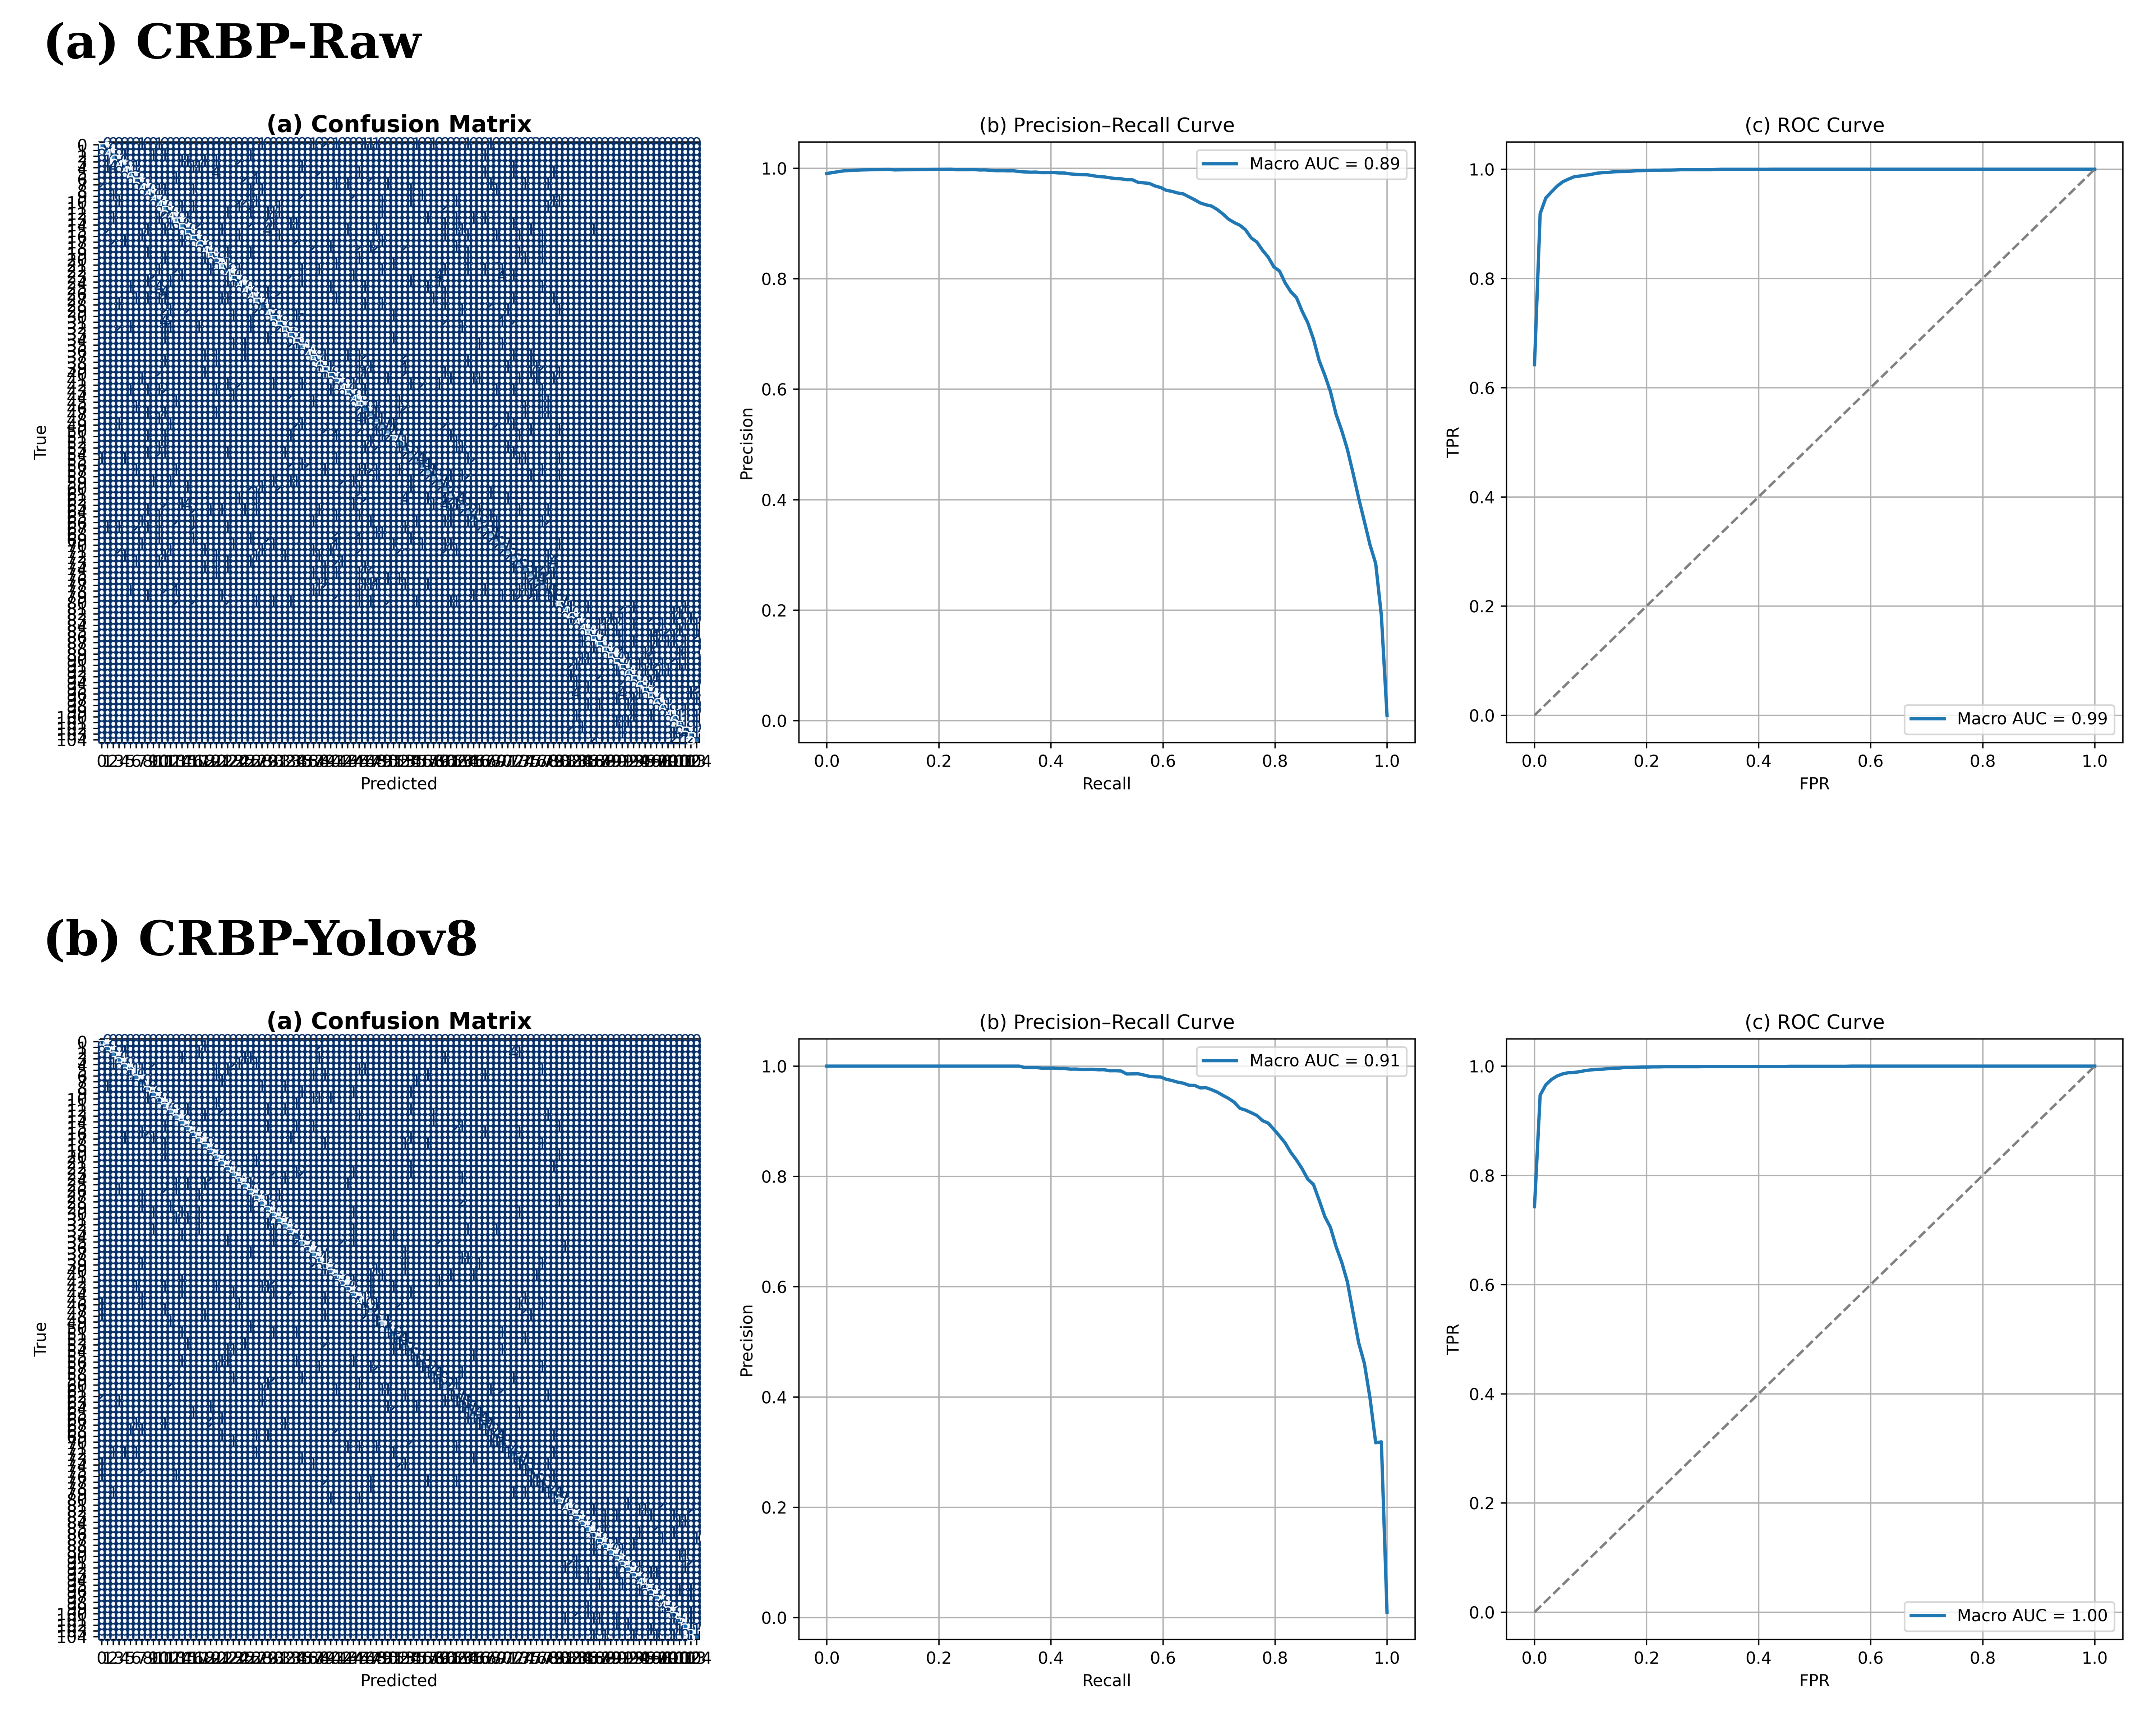

In [19]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# Reload images
img1_path = "/content/CRBP/ML/Visualizations/CRBP-Raw/final_metrics_triplet.png"
img2_path = "/content/CRBP/ML/Visualizations/CRBP-Yolov8/final_metrics_triplet.png"

# Check for existence first
if not (os.path.exists(img1_path) and os.path.exists(img2_path)):
    raise FileNotFoundError("One or both of the images are missing.")

img1 = mpimg.imread(img1_path)
img2 = mpimg.imread(img2_path)

# Create a clean figure with exact control
fig = plt.figure(figsize=(10, 16), dpi=600)

# Subplot 1 — CRBP-Raw
ax1 = fig.add_axes([0.01, 0.51, 0.98, 0.48])  # [left, bottom, width, height]
ax1.imshow(img1)
ax1.text(0.01, 1.05, "(a) CRBP-Raw", transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='bottom', ha='left', family='serif')
ax1.axis('off')

# Subplot 2 — CRBP-Yolov8
ax2 = fig.add_axes([0.01, 0.25, 0.98, 0.48])
ax2.imshow(img2)
ax2.text(0.01, 1.05, "(b) CRBP-Yolov8", transform=ax2.transAxes,
         fontsize=16, fontweight='bold', va='bottom', ha='left', family='serif')
ax2.axis('off')

# Save as high-quality figure
output_clean_path = "/content/CRBP/ML/Visualizations/combined_metrics_vertical.png"
plt.savefig(output_clean_path, dpi=600, bbox_inches='tight')
output_clean_path_pdf = "/content/CRBP/ML/Visualizations/combined_metrics_vertical.pdf"
plt.savefig(output_clean_path_pdf, dpi=600, bbox_inches='tight')


In [18]:
import pandas as pd

# Define file paths
raw_path = "/content/CRBP/ML/Results/CRBP-Raw/metrics_results.csv"
yolo_path = "/content/CRBP/ML/Results/CRBP-Yolov8/metrics_results.csv"

# Load both CSV files
df_raw = pd.read_csv(raw_path)
df_yolo = pd.read_csv(yolo_path)

# Add dataset identifier
df_raw["Dataset"] = "CRBP-Raw"
df_yolo["Dataset"] = "CRBP-Yolov8"

# Combine them
combined_df = pd.concat([df_raw, df_yolo], ignore_index=True)

# Reorder columns for presentation
cols = ["Dataset"] + [col for col in combined_df.columns if col != "Dataset"]
combined_df = combined_df[cols]

print(combined_df)

       Dataset  Accuracy  Balanced Accuracy  Precision   Recall  F1 Score  \
0     CRBP-Raw   0.82875           0.814234   0.836945  0.82875  0.829124   
1  CRBP-Yolov8   0.86000           0.847127   0.867043  0.86000  0.860624   

        MCC   AUC ROC  
0  0.827072  0.995581  
1  0.858595  0.996656  


'/content/CRBP/ML/Visualizations/loss_curves_side_by_side.png'

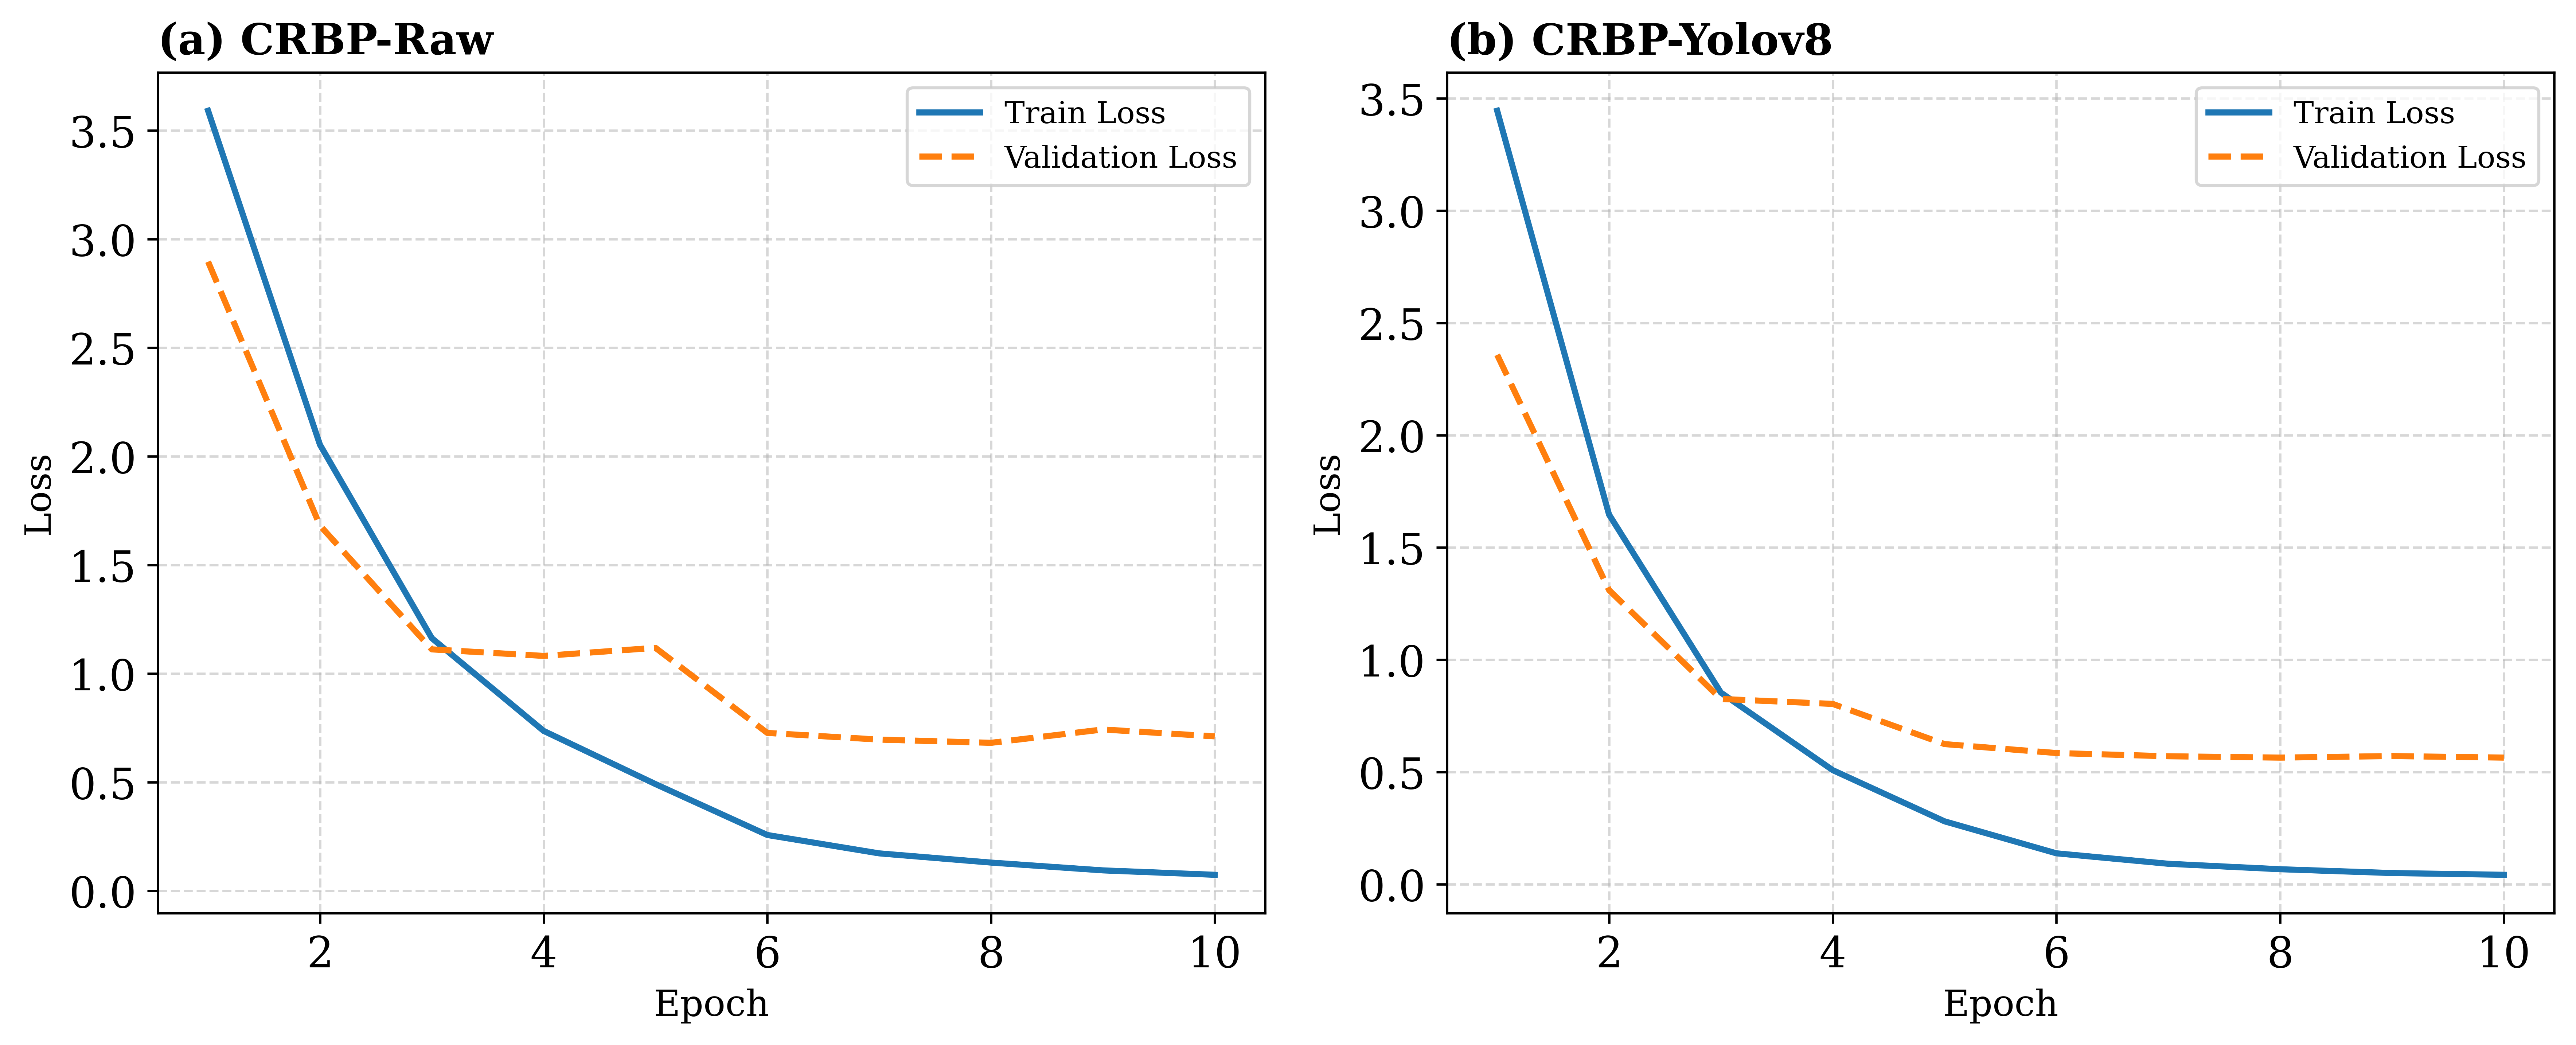

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths to the training history CSVs
history_paths = {
    "CRBP-Raw": "/content/CRBP/ML/Results/CRBP-Raw/training_history.csv",
    "CRBP-Yolov8": "/content/CRBP/ML/Results/CRBP-Yolov8/training_history.csv"
}

# Load both training histories
try:
    history_raw = pd.read_csv(history_paths["CRBP-Raw"])
    history_yolo = pd.read_csv(history_paths["CRBP-Yolov8"])
except FileNotFoundError as e:
    raise FileNotFoundError("One or both of the training history files are missing.") from e

# Plot: 1 row, 2 columns (side-by-side subplots)
fig, axs = plt.subplots(1, 2, figsize=(12, 5), dpi=600)

# Style for both plots
for ax, history, title in zip(axs, [history_raw, history_yolo], ["(a) CRBP-Raw", "(b) CRBP-Yolov8"]):
    ax.plot(history['epoch'], history['train_loss'], label='Train Loss', linewidth=2)
    ax.plot(history['epoch'], history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
    ax.set_xlabel('Epoch', fontsize=12, family='serif')
    ax.set_ylabel('Loss', fontsize=12, family='serif')
    ax.set_title(title, fontsize=14, fontweight='bold', loc='left', family='serif')
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Save the figure
output_dir = "/content/CRBP/ML/Visualizations"
os.makedirs(output_dir, exist_ok=True)
loss_png = os.path.join(output_dir, "loss_curves_side_by_side.png")
loss_pdf = os.path.join(output_dir, "loss_curves_side_by_side.pdf")
plt.savefig(loss_png, dpi=600, bbox_inches='tight')
plt.savefig(loss_pdf, dpi=600, bbox_inches='tight')

loss_png  # Return path to the PNG file for user reference